# 🐕 End-to-end Multi-class Dog Breed classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When Im sitting at a cafe and I take a photo, we need to determine what breed it is.

## 2. Data

The data being used is from Kaggle's dog breed identification competition.

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data:

* We're dealing with images (unstructured data) so its probably best to use deep learning/transfer leanring.

* There are 120 breeds of dogs (this means there are 120 different classes).

* There are around 10,000+ images in the training set (these images have labels)

* There are around 10,000+ images in the test set. (These have no lables because we gotta predict em)


In [1]:
# Import and unzip data
#!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

### Get our Workspace ready

* Import TensorFlow 2.x ✅
* Import TensorFlow Hub
* Make sure to use GPU


In [41]:
# Import TensorFlow into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub Version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESS!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.17.1
TF Hub Version: 0.16.1
GPU available (YESS!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations)

Let's start by accessing data and checking labels.

In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv= pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: xlabel='breed'>

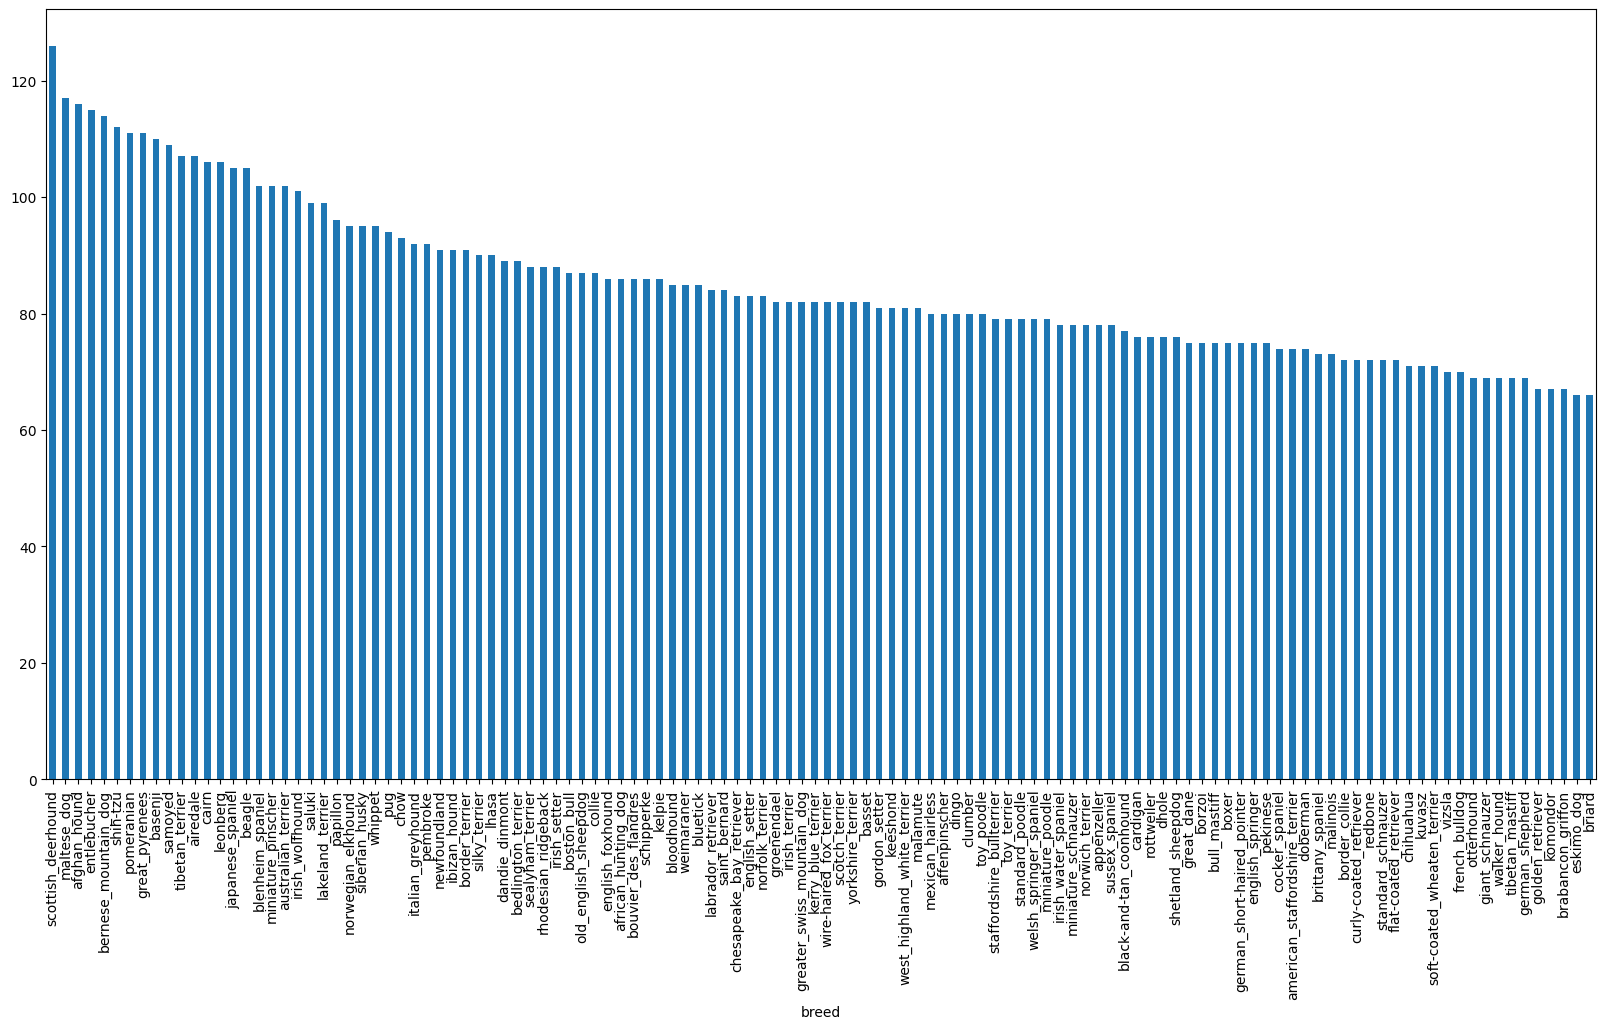

In [4]:
# How many images are there in each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [5]:
labels_csv["breed"].value_counts().median()

82.0

### Getting images and their labels

Let's get a list of all our image file pathnames

In [6]:
# Create pathnames from Image ID's
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]
#Checking the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [7]:
# Check whether number of filenames matches number of actual image files
len(filenames)

10222

In [8]:
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("filenames match actual amount of files, proceed")
else:
  print("Filenames do not match actual amount of files")

filenames match actual amount of files, proceed


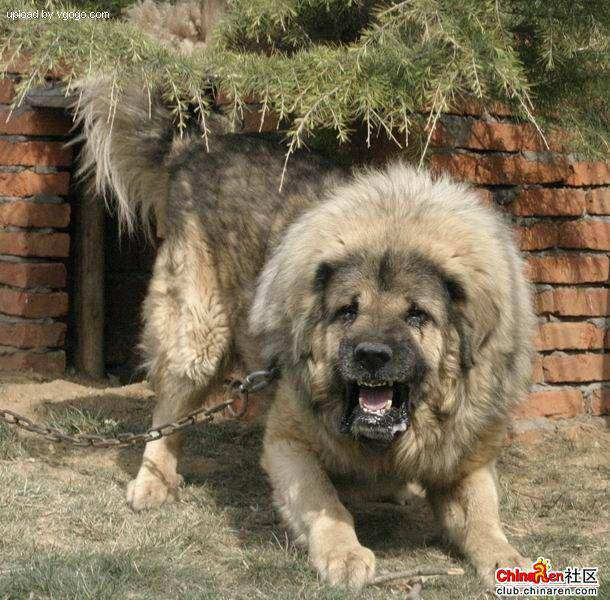

In [9]:
# One more check
from IPython.display import Image
Image(filenames[9000])

In [10]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've got training image filepaths in a list, time for labels!

In [11]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels do not match")

Number of labels matches number of filenames!


In [13]:
# Find unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [14]:
len(unique_breeds)

120

In [15]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every label into a boolean array
boolean_labels= [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
len(boolean_labels)

10222

In [18]:
# Example: Turning boolean array into integers
print(labels[0]) # orginal label
print(np.where(unique_breeds == labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [19]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [20]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Creating our own validation set

Since the dataset from Kaggle does not come with a validation set, we will create our own

In [21]:
# Setup X & y variables
X = filenames
y = boolean_labels

We're going to start off expeimenting with ~1000 images and increase as needs


In [22]:
# Set the number of images to use for experimenting
NUM_IMAGES = 4000 #@param {type:"slider", min:1000, max:10000, step: 1000}

In [23]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

#Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state =42)
len(X_train), len(y_train), len(X_val), len(y_val)

(3200, 3200, 800, 800)

In [24]:
X_train[:2], y_train[:2]

(['drive/My Drive/Dog Vision/train/6338aedbf9de0ccbc208bdc99f8f2431.jpg',
  'drive/My Drive/Dog Vision/train/0a3f1898556115d6d0931294876cd1d9.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

## Preprocessing Images (turning Images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read a file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize `image` into same shape of (224, 224)
5. Return modified `image`

In [25]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [26]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [27]:
tf.constant(image[:2])

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like a Tensor, let's make a function to preprocess them

In [55]:
# Define image size
IMG_SIZE = 128

# Create a function for preprocessing imgaes
def process_image(image_path):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn jpeg image into numerical Tensor with 3 color channels(Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels = 3)
  # Convert color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go.... they all might not fit into memory.

So that's why we do about 32 (this is batch size) images at a time (you can manually adjust batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this : (image, label)

In [56]:
# Create a simple function to return a tuple(image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and associated label, processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [57]:
# Demo of above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0.27929032, 0.4751063 , 0.2795834 ],
         [0.27585176, 0.46525738, 0.26177704],
         [0.3406097 , 0.52753276, 0.30271655],
         ...,
         [0.2751685 , 0.49869794, 0.29869792],
         [0.28818935, 0.51209253, 0.31603253],
         [0.29382864, 0.52127963, 0.33304432]],
 
        [[0.21575989, 0.41348663, 0.2655423 ],
         [0.29273564, 0.48136288, 0.32789788],
         [0.3189494 , 0.505239  , 0.33296594],
         ...,
         [0.25343138, 0.47303924, 0.28489584],
         [0.2582874 , 0.4802207 , 0.2991575 ],
         [0.27520525, 0.49873468, 0.32627755]],
 
        [[0.1963847 , 0.39246315, 0.28385404],
         [0.2122244 , 0.4047182 , 0.29629302],
         [0.22513789, 0.41602883, 0.29334742],
         ...,
         [0.22732845, 0.44489893, 0.27724636],
         [0.23500296, 0.45068926, 0.2900581 ],
         [0.25955886, 0.47524515, 0.32041976]],
 
        ...,
 
        [[0.13864364, 0.17785932

Now we've got a way to turn our data into tuples of Tensors
in the form : `(image, label)`, let's make a function to turn all our data of `(x&y)` into batches

In [58]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size= BATCH_SIZE, valid_data=False, test_data = False):
  """
  Creates batches of data out of image (X) and label (y) pairs
  Shuffles the data if it's training data but doesnt shuffle if its validation data.
  Also accepts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If data is a valid dataset, don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepath
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathna,es and labels before mapping image processor function is faster than shuffling data
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples( this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)
    # Turning into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [59]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches....


In [60]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand, let's visualize

In [61]:
import matplotlib.pyplot as plt

In [62]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  #Setup the figure
  plt.figure(figsize=(10, 10))
  #Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots( 5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid luines off
    plt.axis("off")

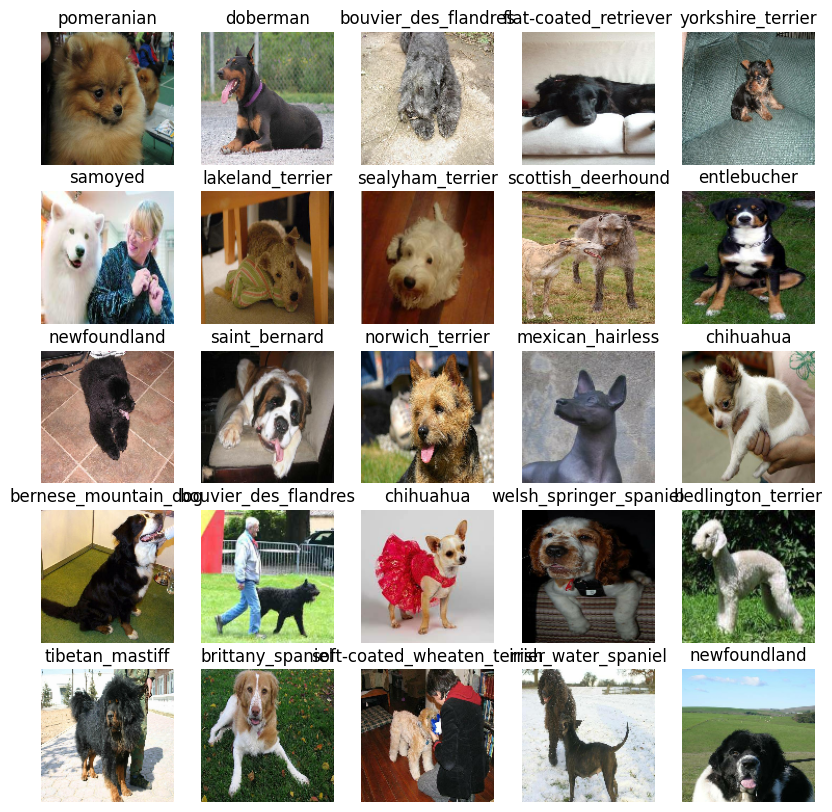

In [63]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

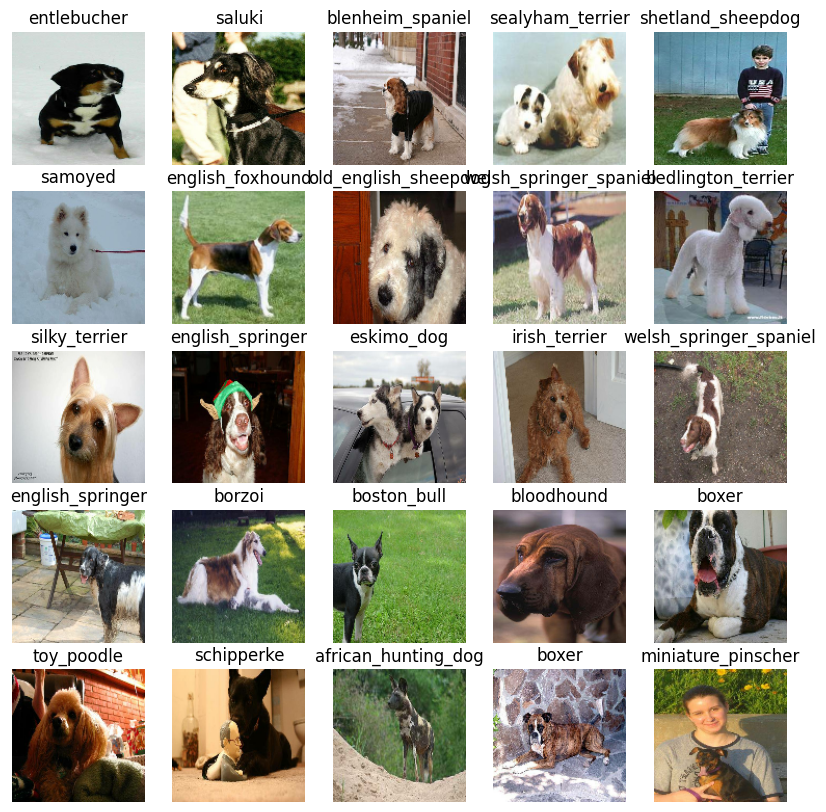

In [64]:
# now to visualize validation sets
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things, we need to define:
* the input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use

In [65]:
# Setup imput shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"

In [66]:
len(unique_breeds)

120

Now we've got our inputs, outputs and model ready to go. Let's put them togethre into a Kera Deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and thwe model we've chosen as parameters.
* Defines the layers in a Keras Model in sequential fashion (do this first, then this, then that)
* Compiles the model (says it should be evaluated and improved.)
* Build the model ( tells the model the inpuit shape it'll be getting)
* Returns the model

All of these steps can be found on tensorflow/keras

In [73]:
# Create a function which builds a keras model
import tensorflow_hub as hub # Import TensorFlow Hub
import tensorflow as tf
import tf_keras

def create_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), output_shape=OUTPUT_SHAPE, model_url=MODEL_URL): # Changed input_shape
  print("Building model with:", MODEL_URL)

  # Create the TensorFlow Hub layer
  # Define hubs_layer here and set trainable to False.
  hub_layer = hub.KerasLayer(handle=model_url, trainable=False, input_shape=input_shape)

  # Setup the model layers
  model = tf_keras.Sequential([
    hub_layer,  # Use the defined hub_layer directly as the input layer
    tf_keras.layers.Dense(units=output_shape, activation="softmax")
  ])
  # Compile the model
  model.compile(
      loss=tf_keras.losses.CategoricalCrossentropy(),
      optimizer=tf_keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model (no longer needed since using Hub layer directly)
  # model.build(INPUT_SHAPE)

  return model

In [74]:
model=create_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2


In [75]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 1001)              1692489   
                                                                 
 dense_3 (Dense)             (None, 120)               120240    
                                                                 
Total params: 1812729 (6.92 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


## Creating callbacks

Callbacks are helper function that our model can use during training to do things such as save it's progress, check it's progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a tensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard`magic function.

In [76]:
# load tensorBoard notebook extension
%load_ext tensorboard

In [83]:
import datetime

# Create a function to build a TensorBoard Callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%d&m&Y-%H%M%S")
                        )
  return tf_keras.callbacks.TensorBoard(logdir)

### Early stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [84]:
# Create early stopping callback
early_stopping = tf_keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on a subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.


In [85]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation set, number of epochs to train for `(NUM_EPOCHS)` and the callbacks we'd like to use
* Return the model

In [86]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained model
  """
  model = create_model()

  # Create new TensorBoard Session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x = train_data,
            epochs= NUM_EPOCHS,
            validation_data = val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # return fitted model
  return model

In [87]:
# Fit the model
model = train_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2
Epoch 1/100
100/100 [==============================] - 1527s 15s/step - loss: 3.9867 - accuracy: 0.1716 - val_loss: 2.8278 - val_accuracy: 0.3050
Epoch 2/100
100/100 [==============================] - 16s 162ms/step - loss: 1.6778 - accuracy: 0.5600 - val_loss: 2.5605 - val_accuracy: 0.3638
Epoch 3/100
100/100 [==============================] - 14s 144ms/step - loss: 1.0407 - accuracy: 0.7234 - val_loss: 2.5420 - val_accuracy: 0.3938
Epoch 4/100
100/100 [==============================] - 14s 141ms/step - loss: 0.6575 - accuracy: 0.8469 - val_loss: 2.5857 - val_accuracy: 0.3675
Epoch 5/100
100/100 [==============================] - 14s 142ms/step - loss: 0.4418 - accuracy: 0.9203 - val_loss: 2.6114 - val_accuracy: 0.3787
Epoch 6/100
100/100 [==============================] - 14s 143ms/step - loss: 0.2955 - accuracy: 0.9663 - val_loss: 2.6703 - val_accuracy: 0.3738
